<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simple-Way" data-toc-modified-id="Simple-Way-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simple Way</a></span></li><li><span><a href="#Adding-Time-Split-Into-Cyclical-Variables" data-toc-modified-id="Adding-Time-Split-Into-Cyclical-Variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Adding Time-Split Into Cyclical Variables</a></span></li><li><span><a href="#Converting-Planet-Angles-to-One-Hot-Encodings" data-toc-modified-id="Converting-Planet-Angles-to-One-Hot-Encodings-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Converting Planet Angles to One-Hot Encodings</a></span><ul class="toc-item"><li><span><a href="#Let's-proceed-with-encoding-all-planets" data-toc-modified-id="Let's-proceed-with-encoding-all-planets-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Let's proceed with encoding all planets</a></span></li></ul></li><li><span><a href="#Next-steps" data-toc-modified-id="Next-steps-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Next steps</a></span></li><li><span><a href="#Old-School-Way" data-toc-modified-id="Old-School-Way-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Old School Way</a></span><ul class="toc-item"><li><span><a href="#Generate-a-whole-set-of-dates,-spaced-every-2H" data-toc-modified-id="Generate-a-whole-set-of-dates,-spaced-every-2H-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Generate a whole set of dates, spaced every 2H</a></span></li></ul></li></ul></div>

In [248]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [240]:
from skyfield.api import load
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from skyfield.api import utc
from scipy.optimize import brentq # machine learning

from datetime import timedelta, datetime
import pytz

In [250]:
from definitions import *

In [389]:
from_binary_to_element_symbols = {
    '11': '🜁',
    '01': '🜂',
    '10': '🜄',
    '00': '🜃',
}

from_binary_to_element_ix = {
    '11': '0',
    '01': '1',
    '10': '2',
    '00': '3',
}

In [390]:
b_to_q = lambda x: [from_binary_to_element_symbols[x[i:i+2]] for i in [1,2,3]]
b_to_q_el = lambda x: [from_binary_to_element_ix[x[i:i+2]] for i in [1,2,3]]

In [391]:
from_binary_to_element_symbols['00']

'🜃'

In [393]:
print ( b_to_q('000000'))
print ( b_to_q_el('000000'))

['🜃', '🜃', '🜃']
['3', '3', '3']


In [398]:
# index elemental composition of the I Ching
iching_ix = [b_to_q_el(str(x['binary']))for x in iching]

In [399]:
# binary position of the I Ching
iching_binary = [b_to_q(str(x['binary']))for x in iching]

In [400]:
# important parameters
design_offset = 88 * math.pi / 180 # required to determine design parameters
earth_offset = math.pi # earth offset (180* against the sun)
pi2 = math.pi*2 # circle constant

# Important parameters and statistics for mandala wheel calculation
hex_width = pi2/64
line_width = hex_width/6
color_width = line_width/6
tone_width = color_width/6
base_width = tone_width/5

In [401]:
# Credits to Ra Uru Hu for receiving this info
iching_map = [36, 22, 63, 37, 55, 30, 49, 13, 19, 41, 60, 61, 54, 38, 58, 10, 11, 26, 5, 9, 34, 14, 43, 1, 44, 28, 50, 32, 57, 48, 18, 46, 6, 47, 64, 40, 59, 29, 4, 7, 33, 31, 56, 62, 53, 39, 52, 15, 12, 45, 35, 16, 20, 8, 23, 2, 24, 27, 3, 42, 51, 21, 17, 25]
iching_map.reverse() 

In [4]:
# how precise decimals are shown in table
pd.set_option('display.float_format', '{:.10f}'.format)

In [5]:
# load Ephemeris
# load library planet position file
planets = load('de431t.bsp')

_planets = {
    "sun": planets['SUN'],
    "earth": planets['EARTH'],
    "moon": planets['MOON'],
    "mercury": planets['MERCURY'],
    "venus": planets['VENUS BARYCENTER'],
    "mars": planets['MARS BARYCENTER'],
    "jupiter": planets['JUPITER BARYCENTER'],
    "saturn": planets['SATURN BARYCENTER'],
    "uranus": planets['URANUS BARYCENTER'],
    "neptune": planets['NEPTUNE BARYCENTER'],
    "pluto": planets['PLUTO BARYCENTER'],
}

In [6]:
ts = load.timescale(builtin=True)

## Simple Way

In [7]:
# For iInfo Purposes
# lat = _planets['earth'].at(t_time_array).observe(_planets['venus']).ecliptic_latlon()[0].radians - *math.pi
# lon = _planets['earth'].at(t_time_array).observe(_planets['venus']).ecliptic_latlon()[1].radians - math.pi
# d   = _planets['earth'].at(t_time_array).observe(_planets['venus']).ecliptic_latlon()[2]

In [8]:
def generate_planets(time_range):
    """ Generates a dataframe for the registered collection of dates """
    df = pd.DataFrame()
    df['time'] = np.array(time_range.tt)

    for planet_name, p in _planets.items():
        earth_offset = math.pi if planet_name == "earth" else 0.0
        df[planet_name] = _planets['earth'].at(time_range).observe(p).ecliptic_latlon()[1].radians + earth_offset # latitude
        
    return df

In [12]:
hours_in_100_years = 24 * 365 * 10
t_time_array = ts.utc(2010, 1, 1, range(0,hours_in_100_years), 0) # -3000 BC to 3000 BC, increments in hours

df_planets = generate_planets(t_time_array) # takes a while

In [13]:
df_planets.tail()

,time,sun,earth,moon,mercury,venus,mars,jupiter,saturn,uranus,neptune,pluto
87595,2458847.2924326854,4.8430998981,3.1415926536,5.5718318039,4.7237048836,5.4354951159,4.1299740076,4.8152313872,5.0766074393,0.5661538211,6.0379774112,5.0971295605
87596,2458847.3340993519,4.8438412701,3.1415926536,5.5807373298,4.7248425179,5.4363875792,4.1304624685,4.8153990169,5.0766920783,0.5661461710,6.0379906416,5.0971533294
87597,2458847.3757660189,4.8445826421,3.1415926536,5.5896363789,4.7259802905,5.4372800222,4.1309509389,4.8155666457,5.0767767259,0.5661385463,6.0380038877,5.0971771018
87598,2458847.4174326854,4.8453240144,3.1415926536,5.5985290190,4.7271182016,5.4381724448,4.1314394187,4.8157342738,5.0768613820,0.5661309472,6.0380171496,5.0972008776
87599,2458847.4590993519,4.8460653867,3.1415926536,5.6074153091,4.7282562515,5.4390648471,4.1319279081,4.8159019010,5.0769460468,0.5661233735,6.0380304273,5.0972246570


In [14]:
len(df_planets)

87600

## Add Elemental Component To It

In [15]:
import math

In [16]:
math.pi

3.141592653589793

In [17]:
# for one rad, return array of elements

# for one row, return array of elements

# for one 

In [18]:
df_planets.apply(lambda x: x/(math.pi**2))

,time,sun,earth,moon,mercury,venus,mars,jupiter,saturn,uranus,neptune,pluto
0,248763.5168533225,0.4957016664,0.3183098862,0.1823108484,0.5108119730,0.4911017644,0.2452199542,0.5768811606,0.3260229937,0.6241482892,0.5737393835,0.4830712400
1,248763.5210750385,0.4957767303,0.3183098862,0.1834188271,0.5107368774,0.4911944714,0.2452085475,0.5768960660,0.3260246713,0.6241501517,0.5737415423,0.4830738959
2,248763.5252967545,0.4958517943,0.3183098862,0.1845271608,0.5106613036,0.4912871783,0.2451970990,0.5769109757,0.3260263434,0.6241520167,0.5737437023,0.4830765516
3,248763.5295184705,0.4959268583,0.3183098862,0.1856358317,0.5105852552,0.4913798850,0.2451856088,0.5769258897,0.3260280101,0.6241538839,0.5737458634,0.4830792071
4,248763.5337401865,0.4960019225,0.3183098862,0.1867448214,0.5105087358,0.4914725917,0.2451740768,0.5769408080,0.3260296713,0.6241557536,0.5737480257,0.4830818625
5,248763.5379619024,0.4960769868,0.3183098862,0.1878541099,0.5104317488,0.4915652983,0.2451625031,0.5769557305,0.3260313270,0.6241576257,0.5737501891,0.4830845176
6,248763.5421836185,0.4961520512,0.3183098862,0.1889636760,0.5103542979,0.4916580049,0.2451508876,0.5769706574,0.3260329773,0.6241595001,0.5737523536,0.4830871725
7,248763.5464053344,0.4962271157,0.3183098862,0.1900735044,0.5102763869,0.4917507113,0.2451392304,0.5769855885,0.3260346221,0.6241613769,0.5737545193,0.4830898272
8,248763.5506270504,0.4963021803,0.3183098862,0.1911835738,0.5101980194,0.4918434177,0.2451275314,0.5770005239,0.3260362615,0.6241632561,0.5737566861,0.4830924817
9,248763.5548487664,0.4963772450,0.3183098862,0.1922938629,0.5101191991,0.4919361240,0.2451157908,0.5770154636,0.3260378953,0.6241651376,0.5737588540,0.4830951361


In [19]:
import seaborn as sns

In [20]:
normalize_squared = lambda x: x/(math.pi**2)
normalize = lambda x: x/(math.pi)
# df_planets.apply(lambda x: x/(math.pi**2))

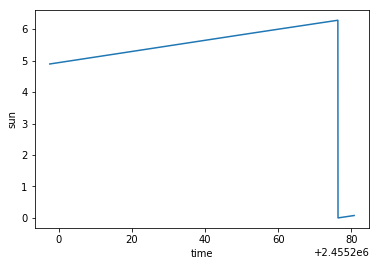

In [21]:
sns.lineplot(x='time', y='sun', data=df_planets[:2000])

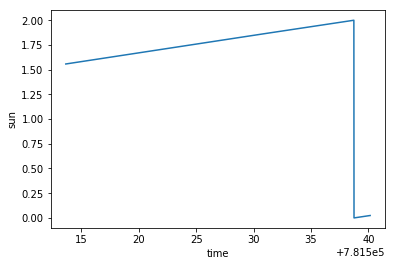

In [22]:
sns.lineplot(x='time', y='sun', data=df_planets.apply(normalize)[:2000])

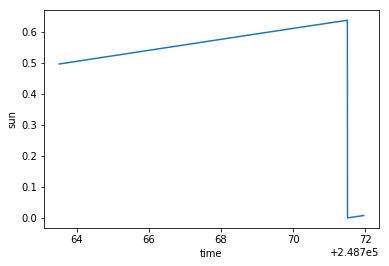

In [23]:
sns.lineplot(x='time', y='sun', data=df_planets.apply(normalize_squared)[:2000])

### Define several functions

In [402]:
def neutron_stream_pos(planet_position):
    """ returns mandala position (base 64) given planet position"""
    return ( (planet_position  + (2*line_width - 1*color_width - 2*tone_width) ) / (2*math.pi) * 64) % 64

In [403]:
def map_on_hexagram(df):
    """ maps df planet positions onto position onto a hexagram and line """
    # convert dataframe to numpy array
    neutron_stream = df.to_numpy()

    hexagram_bin = np.floor(neutron_stream) # rounded up downwards

    # map bin number onto 'hexagram' (neutron stream is sequential order, hexagram is King Wen Sequence)
    strong = np.array(iching_map)
    flat = hexagram_bin.astype(int).flatten()

    previous_shape = neutron_stream.shape
    mapped = strong[flat]

    hexagram = mapped.reshape(previous_shape)
    hexagram_fraction = neutron_stream - hexagram_bin

    line = hexagram_fraction // (1/6) + 1 # count in which 6th this neutrino stream falls in
    line_fraction = (hexagram_fraction - (line - 1)*1/6 ) / (1/6)

    color = line_fraction // (1/6) + 1
    color_fraction = (line_fraction - (color -1) * 1/6) / (1/6)

    tone = color_fraction // (1/6) + 1

    return hexagram #, line.astype(int), color.astype(int), tone.astype(int)

In [404]:
df_angles = neutron_stream_pos(df_planets.iloc[:, 1:6])

In [405]:
df_angles.sample(10).to_numpy()

array([[37.12962557, 32.2962963 , 30.98607355, 35.64018746, 36.92684668],
       [54.07465188, 32.2962963 , 29.76703217, 50.47908288, 45.8482879 ],
       [45.3316223 , 32.2962963 ,  0.71087833, 42.07290342, 50.45596799],
       [41.73368311, 32.2962963 , 27.87879954, 39.44588102, 42.69391155],
       [35.00546532, 32.2962963 ,  9.65660216, 34.96722877, 30.9677015 ],
       [59.00215535, 32.2962963 , 60.0810969 , 54.37299994, 63.94823175],
       [43.45657244, 32.2962963 ,  4.14423486, 40.90262709, 38.20844749],
       [52.0987173 , 32.2962963 , 42.11221403, 48.42006714, 52.21015017],
       [62.7100156 , 32.2962963 , 55.02492534, 62.27430749,  1.24270769],
       [63.93408343, 32.2962963 ,  2.79047975,  3.05351834,  2.87698954]])

In [406]:
z = map_on_hexagram(df_angles)
z

array([[38, 46, 39, 54, 58],
       [38, 46, 39, 54, 58],
       [38, 46, 39, 54, 58],
       ...,
       [58, 46, 49, 10, 19],
       [58, 46, 49, 10, 19],
       [58, 46, 49, 10, 19]])

In [407]:
np.unique(z.flatten())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64])

In [408]:
iching_binary[2]

['🜄', '🜃', '🜃']

In [412]:
many_2_b = np.array(iching_binary) # strong
many_2 = np.array(iching_ix) # strong
one_2 = z.astype(int).flatten() - 1 # flat

In [413]:
# binary el
el_b = many_2_b[one_2]

# normal el (0 -> 3)
el = many_2[one_2]
el

array([['1', '2', '1'],
       ['3', '1', '0'],
       ['2', '1', '2'],
       ...,
       ['0', '0', '2'],
       ['0', '2', '1'],
       ['3', '3', '1']], dtype='<U1')

In [414]:
el.shape

(438000, 3)

In [415]:
z.shape

(87600, 5)

In [416]:
el.reshape((87600, 5, 3))

array([[['1', '2', '1'],
        ['3', '1', '0'],
        ['2', '1', '2'],
        ['1', '2', '1'],
        ['0', '2', '1']],

       [['1', '2', '1'],
        ['3', '1', '0'],
        ['2', '1', '2'],
        ['1', '2', '1'],
        ['0', '2', '1']],

       [['1', '2', '1'],
        ['3', '1', '0'],
        ['2', '1', '2'],
        ['1', '2', '1'],
        ['0', '2', '1']],

       ...,

       [['0', '2', '1'],
        ['3', '1', '0'],
        ['0', '0', '2'],
        ['0', '2', '1'],
        ['3', '3', '1']],

       [['0', '2', '1'],
        ['3', '1', '0'],
        ['0', '0', '2'],
        ['0', '2', '1'],
        ['3', '3', '1']],

       [['0', '2', '1'],
        ['3', '1', '0'],
        ['0', '0', '2'],
        ['0', '2', '1'],
        ['3', '3', '1']]], dtype='<U1')

In [417]:
finish = el.reshape((87600, 15))
finish

array([['1', '2', '1', ..., '0', '2', '1'],
       ['1', '2', '1', ..., '0', '2', '1'],
       ['1', '2', '1', ..., '0', '2', '1'],
       ...,
       ['0', '2', '1', ..., '3', '3', '1'],
       ['0', '2', '1', ..., '3', '3', '1'],
       ['0', '2', '1', ..., '3', '3', '1']], dtype='<U1')

In [418]:
pd.DataFrame(finish)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1,2,1,3,1,0,2,1,2,1,2,1,0,2,1
1,1,2,1,3,1,0,2,1,2,1,2,1,0,2,1
2,1,2,1,3,1,0,2,1,2,1,2,1,0,2,1
3,1,2,1,3,1,0,2,1,2,1,2,1,0,2,1
4,1,2,1,3,1,0,2,1,2,1,2,1,0,2,1
5,1,2,1,3,1,0,2,1,2,1,2,1,0,2,1
6,1,2,1,3,1,0,2,1,2,1,2,1,0,2,1
7,1,2,1,3,1,0,2,1,2,1,2,1,0,2,1
8,1,2,1,3,1,0,2,1,2,1,2,1,0,2,1
9,1,2,1,3,1,0,2,1,2,1,2,1,0,2,1


In [386]:
import seaborn as sns

In [387]:
uniform_data = np.random.rand(10, 12)

In [423]:
data = finish.astype(int)

In [422]:
ax = sns.heatmap(data[100:200, 100:200])

NameError: name 'data' is not defined

In [352]:
iching_binary[z.flatten()]

TypeError: only integer scalar arrays can be converted to a scalar index

## Adding Time-Split Into Cyclical Variables

We want to convert the julian-time to a series of values of increment

In [141]:
t = df.time[0]
t

2415020.5004882407

In [742]:
def test_get_buckets(j_tt, mod_period):
    for index, rotor in enumerate(range(-10,9)):
        print ( math.floor(j_tt % (mod_period**rotor) / (mod_period**rotor) * mod_period) , '%', (mod_period**rotor))
        
def value_to_rotor(j_tt, mod_period, n_rotor_range_min=-15, n_rotor_range_max=15):
    """ Returns rotary bins. Mod_periods=2 returns binary. mod_period=10 returns decimal arrangement
    
        Good default value for n_rotor_range = 10 (this defines how many rotors there are)
    """
    rotor = []
    for r in range(n_rotor_range_min, n_rotor_range_max):
        rot = math.floor(j_tt % (mod_period**r) / (mod_period**r) * mod_period)
        rotor.append(rot)

    return rotor

def rotor_to_value(rotor, mod_period, n_rotor_range_min=-15, n_rotor_range_max=15):
    """ Converts rotary bins back to a decimal value """
    
    julian_time = 0.0
    print (n_rotor_range_min, n_rotor_range_max)
    for index, r in enumerate(range(n_rotor_range_min, n_rotor_range_max)):

        julian_time += rotor[index] * (mod_period**(r+1)) / (mod_period**2)
    
    return julian_time

def encode_value_to_one_hot_rotor(value, mod_period, n_rotor_range_min=-15, n_rotor_range_max=15):
    """ Converts a value to a 1-hot encoded rotor array """
    values = value_to_rotor(value, mod_period, n_rotor_range_min, n_rotor_range_max) # get time rotation of j_tt (julian)
    n_values = mod_period # = max value of period
    return np.eye(n_values)[values].flatten()

def decode_one_hot_rotor_to_value(flat_1hot_rotor, mod_period, n_rotor_range_min=-15, n_rotor_range_max=15):
    """ Converts a one hot rotor back to a value """
    
    # convert to the numpy useful one-hot encoding of the different bins (there mod_period amount in every encoding)
    onehot = np.reshape(flat_1hot_rotor, (int(len(flat_1hot_rotor)/mod_period),mod_period))
    
    # get rotor values (1hot -> category array)
    rotor = np.argmax(onehot, axis=1)
    
    # convert to value
    value = rotor_to_value(rotor, mod_period, n_rotor_range_min, n_rotor_range_max)
    
    return value

In [734]:
# small little test for the bucketing system
print (df.time[0])
test_get_buckets(df.time[0], 10) # test

2415020.5004882407
4 % 1e-10
5 % 1e-09
0 % 1e-08
4 % 1e-07
2 % 1e-06
8 % 1e-05
8 % 0.0001
4 % 0.001
0 % 0.01
0 % 0.1
5 % 1
0 % 10
2 % 100
0 % 1000
5 % 10000
1 % 100000
4 % 1000000
2 % 10000000
0 % 100000000


In [735]:
# below snippet is how to create categorical variables
values = [1, 0, 3]
categories = np.eye(4)[values] # 4 categories
categories

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [736]:
# back to category array
np.argmax(categories, axis=1)

array([1, 0, 3])

In [737]:
# further testing
r = value_to_rotor(df.time[0], 4, -15, 15)
print ("Julian time:", df.time[0])
print("to")
print ("Rotor encoded:",r)

Julian time: 2415020.5004882407
to
Rotor encoded: [2, 0, 1, 1, 3, 3, 3, 3, 3, 3, 1, 0, 0, 0, 0, 2, 0, 3, 2, 2, 1, 2, 1, 3, 0, 1, 2, 0, 0, 0]


In [744]:
_t = rotor_to_value(r, 4, -15, 15)
print("Rotor encoded:",r)
print("to")
print("Julian Time from rotor", _t)

-15 15
Rotor encoded: [2, 0, 1, 1, 3, 3, 3, 3, 3, 3, 1, 0, 0, 0, 0, 2, 0, 3, 2, 2, 1, 2, 1, 3, 0, 1, 2, 0, 0, 0]
to
Julian Time from rotor 2415020.5004882407


In [845]:
def test_encode_decode(value, mod_rotor, n_rotor_range_min, n_rotor_range_max):

    a_time_rotor = encode_value_to_one_hot_rotor(value, mod_rotor, n_rotor_range_min, n_rotor_range_max)
    value_decoded = decode_one_hot_rotor_to_value(a_time_rotor, mod_rotor, n_rotor_range_min, n_rotor_range_max)
    print ("Julian time:", value)
    print ("Flat One Hot Array:", a_time_rotor, " with length:", len(a_time_rotor))
    print ("Decoded Rotor:", value_decoded)
    print ("Error:", value_decoded - value)

In [846]:
test_encode_decode(df.time[1000], 4, -15, 15)

-15 15
Julian time: 2415062.1671549077
Flat One Hot Array: [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]  with length: 120
Decoded Rotor: 2415062.1671549077
Error: 0.0


We'll be adding all these arrays to a dataframe, then transposing it to get the dummy values.

In [762]:
# this might take a time... It creates a dataframe from a series of values (like a column)
def value_array_to_rotor_df(value_array, prefix="_", mod_rotor = 4, n_rotor_range_min=-15, n_rotor_range_max=15):

    encode = np.zeros((len(value_array),mod_rotor*(n_rotor_range_max-n_rotor_range_min)))

    # do it across our time_range (currently in use)
    time_rotors = []
    for ii, t in enumerate(value_array):
        encode[ii,:] = np.array(encode_value_to_one_hot_rotor(t, mod_rotor, n_rotor_range_min, n_rotor_range_max))

    df_rotor = pd.DataFrame(encode)
    df_rotor = df_rotor.add_prefix(prefix)

    return df_rotor

In [764]:
df_time_rotor = value_array_to_rotor_df(t_time_array.tt, "time_rot_", 4, -15, 15)

In [765]:
df_time_rotor.head()

,time_rot_0,time_rot_1,time_rot_2,time_rot_3,time_rot_4,time_rot_5,time_rot_6,time_rot_7,time_rot_8,time_rot_9,...,time_rot_110,time_rot_111,time_rot_112,time_rot_113,time_rot_114,time_rot_115,time_rot_116,time_rot_117,time_rot_118,time_rot_119
0,0.0000000000,0.0000000000,1.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,...,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000
1,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000
2,1.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000
3,0.0000000000,0.0000000000,1.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,...,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000
4,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000


In [766]:
len(df_time_rotor)

876000

In [767]:
encode.shape

(100, 120)

Now add `time_rot_` to `df_planets`, containing our ephimeris. It essentially displays time as a series of buckets

In [768]:
df_planets_with_trotor = df_planets.merge(df_time_rotor, left_index=True, right_index=True)
df_planets_with_trotor.head()

,time,sun,earth,moon,mercury,venus,mars,jupiter,saturn,uranus,...,time_rot_110,time_rot_111,time_rot_112,time_rot_113,time_rot_114,time_rot_115,time_rot_116,time_rot_117,time_rot_118,time_rot_119
0,2415020.5004882407,4.9139988284,3.1415926536,4.7790792273,4.5447599779,5.3716391230,4.9788254865,4.2329877905,4.6969294963,4.3901325057,...,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000
1,2415020.5421549077,4.9147404218,3.1415926536,4.7895000534,4.5456886992,5.3725433572,4.9793857048,4.2331299323,4.6970140338,4.3901726600,...,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000
2,2415020.5838215742,4.9154820157,3.1415926536,4.7999305701,4.5466182272,5.3734475816,4.9799459428,4.2332720395,4.6970985632,4.3902128023,...,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000
3,2415020.6254882407,4.9162236103,3.1415926536,4.8103706577,4.5475485580,5.3743517962,4.9805062005,4.2334141122,4.6971830845,4.3902529325,...,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000
4,2415020.6671549077,4.9169652056,3.1415926536,4.8208202389,4.5484796881,5.3752560010,4.9810664780,4.2335561504,4.6972675976,4.3902930506,...,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000


We quickly check if the values are correctly encoded:

In [769]:
# Testing of time rotor values

filter_col = [col for col in df_planets_with_trotor if col.startswith('time_rot_')]

print ("Julian Time:",df_planets_with_trotor.loc[5500,'time'])
rot = np.array(df_planets_with_trotor.loc[5500,filter_col])
print ("Rotor:", rot)

Julian Time: 2415249.6671549077
Rotor: [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]


In [771]:
decode_one_hot_rotor_to_value(rot, 4, -15, 15)

-15 15


2415249.6671549077

## Converting Planet Angles to One-Hot Encodings

In [773]:
print (df_planets_with_trotor.jupiter.min()  * 180.0 / math.pi )
print (df_planets_with_trotor.jupiter.max()  * 180.0 / math.pi )

0.0003493438621863469
359.9999345420169


First let's determine optimale rotor_count (range)

In [832]:
print ("Our maximum difference between 2 values is is maximum this value", df_planets_with_trotor.sun.diff().max())
print ("So let's not add useless precision to the onehot encoding")

Our maximum difference between 2 values is is maximum this value 0.0007415992627457513
So let's not add useless precision to the onehot encoding


In [853]:
val = df_planets_with_trotor.sun.max()
test_encode_decode(val, 4, -10, 3) # optimale parameters for 0 error

val = df_planets_with_trotor.sun.min()
test_encode_decode(val, 4, -10, 3) # optimale parameters for 0 error

-10 3
Julian time: 6.283182822518666
Flat One Hot Array: [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0.]  with length: 52
Decoded Rotor: 6.283182621002197
Error: -2.0151646840105286e-07
-10 3
Julian time: 1.331978542433677e-05
Flat One Hot Array: [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0.]  with length: 52
Decoded Rotor: 1.3113021850585938e-05
Error: -2.0676357375083306e-07


Above errors are small enough to proceed with this encoding.

### Let's proceed with encoding all planets

In [839]:
planets = ['moon', 'mercury', 'venus', 'sun', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune', 'pluto']

In [842]:
for planet_name in planets:
    print ("Encoding:", planet_name)
    # calculate rotor for planet
    df_planet_rotor = \
        value_array_to_rotor_df(df_planets_with_trotor[planet_name], planet_name+"_rot_", 4, -10, 3)
        
    # add planet to `df_planets_with_trotor`
    df_planets_with_trotor = df_planets_with_trotor.merge(df_planet_rotor, left_index=True, right_index=True)
    

Encoding: moon
Encoding: mercury
Encoding: venus
Encoding: sun
Encoding: mars
Encoding: jupiter
Encoding: saturn
Encoding: uranus
Encoding: neptune
Encoding: pluto


In [849]:
df_planets_with_trotor.drop('earth', axis=1, inplace=True)
df_planets_with_trotor.head()

,time,sun,moon,mercury,venus,mars,jupiter,saturn,uranus,neptune,...,pluto_rot_42,pluto_rot_43,pluto_rot_44,pluto_rot_45,pluto_rot_46,pluto_rot_47,pluto_rot_48,pluto_rot_49,pluto_rot_50,pluto_rot_51
0,2415020.5004882407,4.9139988284,4.7790792273,4.5447599779,5.3716391230,4.9788254865,4.2329877905,4.6969294963,4.3901325057,1.5115380264,...,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000
1,2415020.5421549077,4.9147404218,4.7895000534,4.5456886992,5.3725433572,4.9793857048,4.2331299323,4.6970140338,4.3901726600,1.5115182044,...,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000
2,2415020.5838215742,4.9154820157,4.7999305701,4.5466182272,5.3734475816,4.9799459428,4.2332720395,4.6970985632,4.3902128023,1.5114983874,...,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000
3,2415020.6254882407,4.9162236103,4.8103706577,4.5475485580,5.3743517962,4.9805062005,4.2334141122,4.6971830845,4.3902529325,1.5114785754,...,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000
4,2415020.6671549077,4.9169652056,4.8208202389,4.5484796881,5.3752560010,4.9810664780,4.2335561504,4.6972675976,4.3902930506,1.5114587685,...,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000


In [852]:
df_planets_with_trotor.to_csv("100_year_rotor_encoded_ephemeris.csv", sep=';', index=False)

In [854]:
len (df_planets_with_trotor)

876000

## Next steps

- Divide dataset in 1/2 (50 years), one for training, one for testing
- Setup input training data:
    - X = Time Rotor input (120)
    - Y = 52 (1 observed sphere) -> the moon (use script to get columns starting with "moon_rot_"
    
When more planets will be active, the loss algorithm should be taking an argmax across "planet rotors", so that the neural network learns the "sphere grouping" across outputs (520 when taking all spheres into account).
    
We train till the precision will be small enough, say E <= 0.00001, should be adequate enough I think.

Then we validate the data on the other 50 years, and we're very anxious for the results.

## Old School Way

In [13]:
def planet1_looks_at_planet2(p1, p2, t):
    return p1.at(t).observe(p2).apparent()

def observe(p1, p2, t):
    """ Observe planet 1 to planet 2 ... observe(p1, p2, timestamp).degrees, or use .radians for radiance """
    t = get_ts(t)

    astrometric = planet1_looks_at_planet2(p1, p2, t)
    _, lon, _ = astrometric.ecliptic_latlon()
    return lon

def getEarthPos(t, planet):
    """ Given a time t and planet p, return longitude position of planet on ecliptic plane """

    return observe(_planets['earth'], planet, t).radians

In [14]:
t = datetime(1, 12, 9, 0, 14, 0, tzinfo=utc)

In [15]:
t

datetime.datetime(1, 12, 9, 0, 14, tzinfo=<UTC>)

In [5]:
t = datetime(1970, 12, 9, 0, 14, 0, tzinfo=utc)
earth = _planets['earth']
jupiter = _planets['jupiter']
observe(earth, jupiter, t).radians

4.072675942197303

### Generate a whole set of dates, spaced every 2H

In [6]:
start = datetime(1970, 1, 1, 0, 0, 0, tzinfo=utc)
end = datetime(2020, 4, 12, 0, 0, 0, tzinfo=utc)
dates = pd.date_range(start = start, end = end, tz=pytz.UTC, freq='2H').to_pydatetime().tolist()

# reason for 2H frequency: we want to divide the day up in 12 segments, which is a nice amount
len(dates)

220369

In [75]:
import math

In [102]:
bodies = ['sun', 'earth', 'moon', 'venus', 'mars', 'jupiter']

positions = {
    'sun': (lambda t: observe(earth,      _planets['sun'], t).radians),
    'earth': (lambda t: observe(earth,    _planets['sun'], t).radians - math.pi),
    'moon': (lambda t: observe(earth,     _planets['moon'], t).radians),
    'venus': (lambda t: observe(earth,  _planets['venus'], t).radians),
    'mars': (lambda t: observe(earth,  _planets['mars'], t).radians),
    'jupiter': (lambda t: observe(earth,    _planets['jupiter'], t).radians)
}

def generate_table(dates):

    new_table = {}
    new_table['t'] = dates

    for b in bodies:
        new_table[b] = [] # assign body nae as key
        for t in dates: # calculate for every date in dates
            body_pos = positions[b](t) # calculate position, using this planet of body
            new_table[b].append( body_pos ) # generate a new table

    df = pd.DataFrame(data=new_table)

    return df

df = generate_table(dates)
df.sample(15)

,t,sun,earth,moon,venus,mars,jupiter
149690,2004-02-26 04:00:00+00:00,5.878904,2.737311,0.791900,0.353795,0.776064,2.876731
125890,1998-09-21 20:00:00+00:00,3.118022,-0.023571,3.334024,2.943443,2.449233,6.149105
73922,1986-11-13 04:00:00+00:00,4.025802,0.884210,0.223293,3.812943,5.612511,5.989845
67042,1985-04-18 20:00:00+00:00,0.504923,-2.636670,0.242316,0.121726,0.958782,5.477937
4485,1971-01-09 18:00:00+00:00,5.048080,1.906488,1.539050,4.238912,4.049131,4.181739
160677,2006-08-29 18:00:00+00:00,2.725605,-0.415987,3.856335,2.454635,3.034209,3.891856
92640,1991-02-20 00:00:00+00:00,5.776359,2.634766,0.621809,6.234074,1.220381,2.198069
182368,2011-08-11 08:00:00+00:00,2.411440,-0.730153,5.047272,2.386536,1.660161,0.691000
52811,1982-01-18 22:00:00+00:00,5.214145,2.072552,4.012284,5.285399,3.382649,3.815142
91068,1990-10-12 00:00:00+00:00,3.465056,0.323463,2.083998,3.372365,1.293873,2.270147


In [104]:
df.to_csv('planets.csv', sep=';')